[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zakizulham/proyek-stokastik-churn-telekomunikasi/blob/main/notebooks/analisis_churn.ipynb)

# Analisis Siklus Hidup Pelanggan dengan Rantai Markov Waktu Diskrit

**Tujuan Notebook:**
1.  Memuat dan melakukan pra-pemrosesan pada dataset Telco Customer Churn.
2.  Mengestimasi parameter dan membangun Matriks Probabilitas Transisi (P) untuk model DTMC 4-state (`New`, `Established`, `Loyal`, `Churn`).
3.  Menganalisis perilaku jangka panjang seorang pelanggan baru.
4.  Memvisualisasikan evolusi probabilitas status pelanggan dari waktu ke waktu.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Atur gaya plot
plt.style.use('seaborn-v0_8-whitegrid')
print("Pustaka berhasil dimuat.")

Pustaka berhasil dimuat.


## 1. Memuat dan Pra-pemrosesan Data

Langkah pertama adalah memuat dataset. Selanjutnya, kita akan membersihkan data dengan menghapus baris yang tidak relevan (tenure = 0) dan membuat kolom baru `TenureGroup` yang akan menjadi dasar untuk 'status' dalam model Markov kita. Status ini merepresentasikan fase siklus hidup pelanggan.

In [ ]:
# Memuat data dari URL publik untuk reproduktifitas
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Atau dari repo jika URL publik tidak dapat digunakan
# url = 'https://raw.githubusercontent.com/zakizulham/proyek-stokastik-churn-telekomunikasi/refs/heads/main/data/Telco-Customer-Churn.csv'

df = pd.read_csv(url)

# Menghapus customer dengan tenure 0 karena tidak memberikan informasi transisi
df = df[df['tenure'] > 0].copy()

# Membuat kategori/bins untuk tenure menjadi status siklus hidup
bins = [0, 12, 48, 72]
labels = ['New', 'Established', 'Loyal']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True)

print("Data berhasil diproses. Lima baris pertama dengan kolom 'TenureGroup':")
display(df[['tenure', 'TenureGroup', 'Churn']].head())

Data berhasil diproses. Lima baris pertama dengan kolom 'TenureGroup':


,tenure,TenureGroup,Churn
0,1,New,No
1,34,Established,No
2,2,New,Yes
3,45,Established,No
4,2,New,Yes


## 2. Estimasi Parameter dan Pembangunan Matriks Transisi

Sekarang kita akan menghitung parameter kunci dari model kita: probabilitas transisi bulanan ($p_{ij}$). Ini dilakukan dengan:
1. Menghitung rasio churn empiris untuk setiap grup (`New`, `Established`, `Loyal`).
2. Menggunakan rasio ini untuk mengestimasi probabilitas bertahan, tetap di status yang sama, atau "lulus" ke status berikutnya.
3. Menyusun probabilitas ini ke dalam sebuah matriks transisi P berukuran 4x4.

In [3]:
# 1. Hitung Churn Rate per Grup Tenure
churn_rate_by_group = df.groupby('TenureGroup', observed=False)['Churn'].value_counts(normalize=True).unstack()

p_new_churn = churn_rate_by_group.loc['New', 'Yes']
p_est_churn = churn_rate_by_group.loc['Established', 'Yes']
p_loyal_churn = churn_rate_by_group.loc['Loyal', 'Yes']

# 2. Hitung Probabilitas Transisi Lainnya dengan asumsi yang telah dibahas
# Durasi setiap state: New (12 bln), Established (36 bln), Loyal (24 bln)
p_new_stay = (11/12) * (1 - p_new_churn)
p_new_graduate = (1/12) * (1 - p_new_churn)

p_est_stay = (35/36) * (1 - p_est_churn)
p_est_graduate = (1/36) * (1 - p_est_churn)

p_loyal_stay = (1) * (1 - p_loyal_churn) # Tidak ada kelulusan dari state Loyal

# 3. Susun Matriks Transisi 4x4 (New, Established, Loyal, Churn)
P = np.array([
    #       New             Established     Loyal           Churn
    [p_new_stay,      p_new_graduate, 0,              p_new_churn],   # Dari New
    [0,               p_est_stay,     p_est_graduate, p_est_churn],   # Dari Established
    [0,               0,              p_loyal_stay,   p_loyal_churn],   # Dari Loyal
    [0,               0,              0,              1]                # Dari Churn (Absorbing)
])

print("Matriks Probabilitas Transisi (P) per Bulan:")
print(np.round(P, 4))

Matriks Probabilitas Transisi (P) per Bulan:
[[0.4796 0.0436 0.     0.4768]
 [0.     0.7423 0.0212 0.2364]
 [0.     0.     0.9049 0.0951]
 [0.     0.     0.     1.    ]]


## 3. Analisis Perilaku Jangka Panjang

Dengan matriks transisi `P`, kita sekarang dapat menganalisis perjalanan seorang pelanggan baru dari waktu ke waktu. Kita akan menghitung distribusi probabilitas statusnya untuk setiap 6 bulan hingga 3 tahun (36 bulan).

In [4]:
# Definisikan vektor status awal (pi_0) untuk pelanggan baru
# Posisi: [New, Established, Loyal, Churn]
pi_0 = np.array([1, 0, 0, 0])

# Daftar periode waktu (n bulan) yang ingin dianalisis
n_months_report = [6, 12, 18, 24, 30, 36]

# Siapkan list untuk menampung hasil tabel
report_results_list = []

# Loop untuk setiap periode waktu
for n in n_months_report:
    # Hitung matriks P pangkat n
    P_n = np.linalg.matrix_power(P, n)
    
    # Hitung distribusi status setelah n bulan
    pi_n = pi_0.dot(P_n)
    
    # Tambahkan hasil ke dalam list
    report_results_list.append({
        'n Bulan': n,
        'P(di New)': pi_n[0],
        'P(di Established)': pi_n[1],
        'P(di Loyal)': pi_n[2],
        'P(di Churn)': pi_n[3]
    })

# Konversi list hasil menjadi DataFrame untuk tampilan yang rapi
report_df = pd.DataFrame(report_results_list).set_index('n Bulan')

print("Tabel: Distribusi Probabilitas Status Pelanggan Baru (untuk Laporan)")
display(report_df.style.format("{:.4f}"))

Tabel: Distribusi Probabilitas Status Pelanggan Baru (untuk Laporan)


,P(di New),P(di Established),P(di Loyal),P(di Churn)
n Bulan,,,,
6,0.0122,0.0258,0.0038,0.9583
12,0.0001,0.0046,0.0034,0.9918
18,0.0000,0.0008,0.0021,0.9971
24,0.0000,0.0001,0.0012,0.9987
30,0.0000,0.0000,0.0007,0.9993
36,0.0000,0.0000,0.0004,0.9996


## 4. Visualisasi Evolusi Pelanggan

Tabel di atas sangat informatif, tetapi visualisasi dapat menceritakan kisah yang lebih kuat. Mari kita plot evolusi probabilitas dari bulan ke-1 hingga bulan ke-48 untuk melihat bagaimana perjalanan seorang pelanggan baru secara visual.

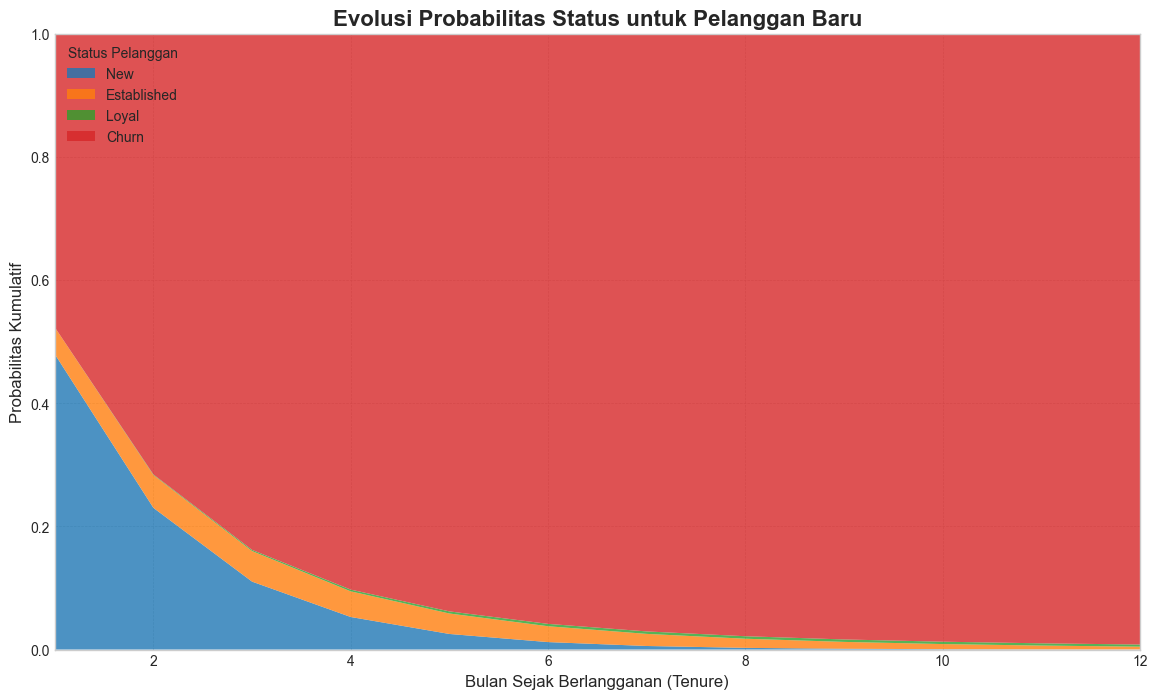

In [5]:
# Hitung probabilitas untuk rentang waktu yang lebih halus untuk plot
n_steps_plot = range(1, 49) # 1 hingga 48 bulan
plot_results_list = []

for n in n_steps_plot:
    pi_n = pi_0.dot(np.linalg.matrix_power(P, n))
    plot_results_list.append(pi_n)

# Buat DataFrame untuk plotting
plot_df = pd.DataFrame(plot_results_list, columns=['New', 'Established', 'Loyal', 'Churn'])
plot_df.index = n_steps_plot # Jadikan bulan sebagai index

# Buat plot
plt.figure(figsize=(14, 8))
# Gunakan stacked area chart untuk menunjukkan bagaimana probabilitas terbagi dan selalu berjumlah 1
plt.stackplot(plot_df.index, plot_df.T, labels=plot_df.columns, alpha=0.8)

# Formatting plot
plt.title('Evolusi Probabilitas Status untuk Pelanggan Baru', fontsize=16, fontweight='bold')
plt.xlabel('Bulan Sejak Berlangganan (Tenure)', fontsize=12)
plt.ylabel('Probabilitas Kumulatif', fontsize=12)
plt.legend(title='Status Pelanggan', loc='upper left')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Simpan gambar jika diperlukan
plt.savefig('../output/plot_distribusi_status.png', dpi=300)

plt.show()

### Interpretasi Visual


Grafik area bertumpuk di atas dengan jelas memvisualisasikan perjalanan probabilitas seorang pelanggan baru dari waktu ke waktu. Beberapa wawasan kunci dapat ditarik:

- **Éksodus Massal pada Fase Awal**: Area Churn (merah) mendominasi plot dengan sangat cepat. Kurva kenaikannya luar biasa curam, terutama dalam **5 hingga 10 bulan pertama**. Ini mengindikasikan bahwa risiko churn tidak hanya tinggi, tetapi bersifat katastrofik pada fase awal. Sebagian besar pelanggan baru yang akan churn, melakukannya dalam waktu yang sangat singkat.

- **Fase `Established` yang Singkat dan Tidak Signifikan**: Berbeda dengan ekspektasi, area `Established` (oranye) hanya muncul sebagai lapisan yang sangat tipis dan singkat. Probabilitas seorang pelanggan untuk berada di status ini tidak pernah tinggi, mencapai puncak yang sangat kecil di sekitar bulan ke-3 atau ke-4, dan kemudian menghilang dengan cepat. Ini menyiratkan bahwa sangat sedikit pelanggan baru yang berhasil "bertahan" cukup lama untuk dianggap mapan; mereka cenderung churn jauh sebelumnya.

- **Probabilitas Menjadi `Loyal` Sangat Rendah**: Area `Loyal` (hijau) pada grafik ini **hampir tidak terlihat sama sekali**. Hal ini memberikan kesimpulan yang kuat bahwa, menurut model ini, kemungkinan seorang pelanggan baru untuk pada akhirnya mencapai status 'Loyal' sangatlah kecil, mendekati nol. Perjalanan menuju loyalitas tampaknya merupakan sebuah anomali, bukan hasil yang umum.

- **Konvergensi Cepat ke Status Churn**: Sesuai dengan teori rantai Markov dengan state penyerap, total area pada akhirnya didominasi oleh `Churn`. Namun, yang menonjol di sini adalah **kecepatan konvergensi tersebut**. Model ini memprediksi bahwa hampir seluruh probabilitas (mendekati 100%) akan terkonsentrasi di status `Churn` bahkan sebelum mencapai bulan ke-20. Ini menunjukkan bahwa, bagi kohort pelanggan baru, churn bukanlah pertanyaan "jika", melainkan "seberapa cepat".